Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


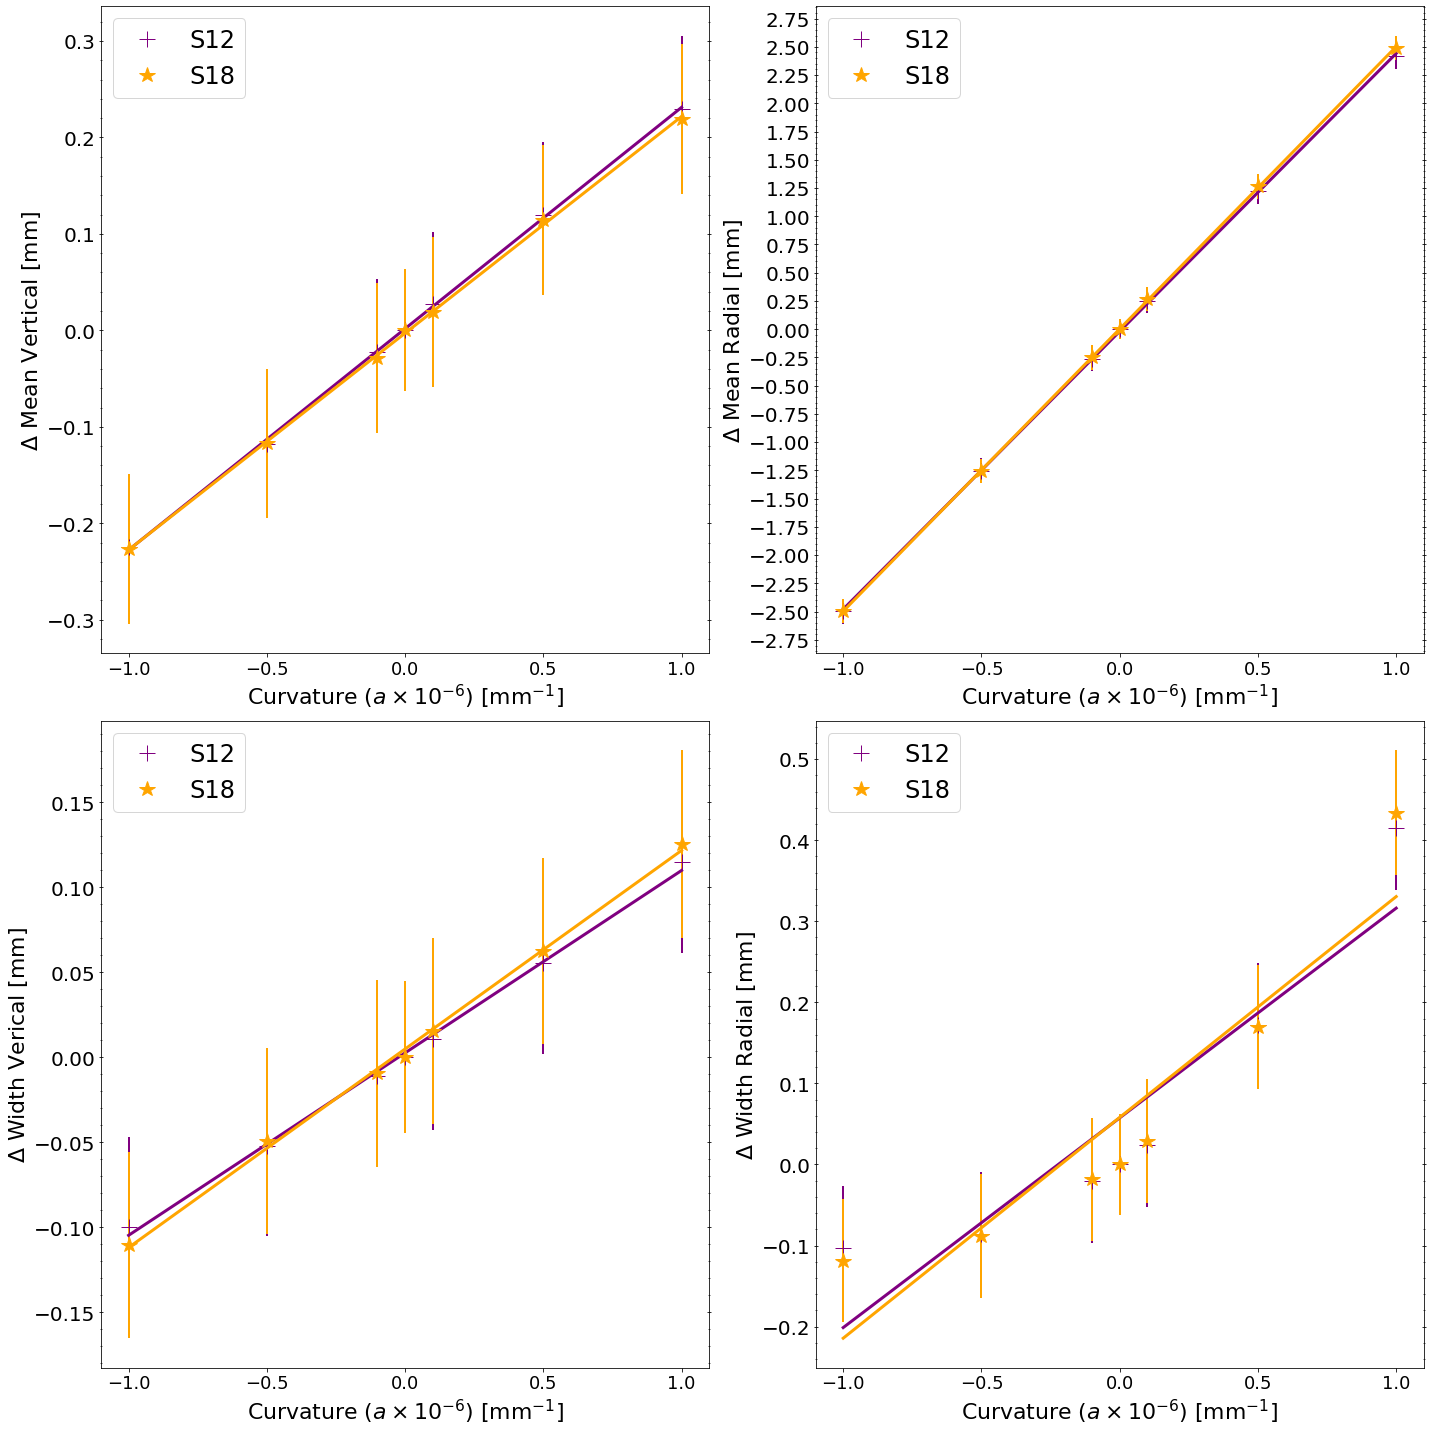

In [10]:
# Juoyer ROOT import 
import sys, os
sys.path.append(os.environ["JUPYROOT"]) 
# ROOT includes 
from ROOT import TH1D, TH2D, TF1, TCanvas, TFile, gStyle, TLegend, gROOT
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt #for plotting  
import numpy.polynomial.polynomial as poly
import matplotlib.ticker as plticker
   
#Define constant paths and labels 
# topDir = "/Users/gleb/software/alignTrack/mpIIDESY/AlignmentData/Curve_sim/"
topDir = "/Users/gleb/software/alignTrack/mpIIDESY/AlignmentData/Curve_data/"
# states=("Truth", "a=+1e-6", "a=-1e-6","a=+0.5e-6", "a=-0.5e-6",  "a=+1e-7", "a=-1e-7")
states=("Truth_noMomSlices", "a=+1e-6", "a=-1e-6","a=+0.5e-6", "a=-0.5e-6",  "a=+1e-7", "a=-1e-7")
stateN = len(states)
fileName="gm2tracker_ana.root"
plotPath="Extrapolation/vertices/station"
stations=[12, 18]
stationN=len(stations)

round_to = 3

#Final plots and canvases names (looped over i_plot)
canvasTitle = ["Vertical", "Radial"]
globalN=len(canvasTitle)
plotName = ["h_verticalPos_vs_time", "h_radialPos_vs_time"]
results = ["<y>", "<x>"]
xTitles= ["Vertical Beam Position", "Radial Beam Position"]

#Legen labels (looped over i_state)
legendName = states
colorLine = [2, 9, 8, 1, 6, 7, 5] # red, blue, green, black, purple, cyan, yellow 
colorHisto = colorLine

#Open TFiles (looped over i_state)

fileArray = [] # keep files in scope
histArray = [] # keep hists in scope
legendArray = [] #keep legends in scope 

#Global empty containers to be filled for vertical or radial (in the main loop)
result = "-1"
mean = -1
mean_error = -1 
sd = -1 
sd_error = -1 
meanArray=[] # for the final FoM shift-nominal 

#for plotting summary plots
widthAll = [[[0 for i_state in range (0, stateN)] for i_global in range(globalN) ] for i_station in range(stationN) ]
widthAll_error = [[[0 for i_state in range (0, stateN)] for i_global in range(globalN)] for i_station in range(stationN) ] 
meanAll = [[[0 for i_state in range (0, stateN)] for i_global in range(globalN) ] for i_station in range(stationN) ] 
meanAll_error = [[[0 for i_state in range (0, stateN)] for i_global in range(globalN) ] for i_station in range(stationN) ] 

###### Plotting ##########
#Make new canvas for plots (4 in total)
canvas = TCanvas("", "", 2000, 1600)
canvas.Divide(stationN, globalN)
i_plot = 1 

for i_station in range(0, stationN):
    for i_global in range(0, globalN):
        legend =  TLegend(0.12,0.4,0.35,0.89)
        canvas.cd(i_plot) # cd for each station and rad/ver
        for i_state in range(0, stateN):
            
            #Get the TH1F 
            filePath = topDir + states[i_state] + "/" + fileName
            fullHistopath = plotPath + str(stations[i_station]) + "/" + plotName[i_global]
            #print(filePath)
            #print(fullHistopath)
            rootFile = TFile.Open(filePath)
            fileArray.append(rootFile)
            
            #Get the TH2F 
            histo_2D = rootFile.Get(fullHistopath)
            #Apply 30 us time cut 
            first_bin = histo_2D.GetXaxis().FindBin(30.0)
            tmpNameTH1 = "tmpNameTH1_"+str(i_plot)+str(i_station)+str(i_state) # assign a new "name pointer" to the TH1 object for each loop 
            
            #Get the TH1F
            hist_1D = histo_2D.ProjectionY(tmpNameTH1, first_bin, -1)
            
            histArray.append(hist_1D)
            
            #Rebin and minipulate the histo 
            hist_1D.Rebin()
            hist_1D.GetXaxis().SetRangeUser(-60, 60) # applying a maximum range cut 
            binN=hist_1D.GetBinWidth(1)
            
            hist_1D.SetTitle("")
            hist_1D.GetYaxis().SetTitle("Tracks / "+str(binN)+" mm")
            hist_1D.GetXaxis().SetTitle(xTitles[i_global] +" [mm]")       
            hist_1D.GetYaxis().SetTitleOffset(1.4)
            hist_1D.GetXaxis().SetTitleOffset(1.4);
            hist_1D.GetYaxis().CenterTitle()
            hist_1D.GetXaxis().CenterTitle()
            
            #Draw on canvas 
            hist_1D.SetLineColor(colorHisto[i_state])
            if (i_state == 0):
                hist_1D.Draw("E1")

            else:
                hist_1D.Draw("E1 same")

            #Get stats from hist 
            mean = hist_1D.GetMean()
            mean_error = hist_1D.GetMeanError()
            sd = hist_1D.GetRMS()
            sd_error = hist_1D.GetRMSError()
            result = results[i_global]
            legenObject = hist_1D
            meanArray.append(mean)
            meanAll[i_station][i_global][i_state]=(mean)
            meanAll_error[i_station][i_global][i_state]=(mean_error)
            widthAll[i_station][i_global][i_state]=(sd)
            widthAll_error[i_station][i_global][i_state]=(sd_error)


            #take care of the legend
            legenValue1 = str(legendName[i_state])+": "+str(result)+": "+str(round(mean,round_to))+" #pm "+str(round(mean_error, round_to)) 
            legenValue2 = "#sigma: "+str(round(sd,round_to))+" #pm "+str(round(sd_error,round_to))
            legend.AddEntry(legenObject,"#splitline{"+str(legenValue1)+"}{           "+str(legenValue2)+"}","L") # make appropriate spacing 
            legend.SetTextSize(.028)
            legend.Draw("same")


        #Do some final massaging per pad 
        legend.SetHeader("S"+str(stations[i_station])+" "+canvasTitle[i_global], "C"); # option "C" allows to center the header
        legendArray.append(legend)
        meanArray=[]
        gStyle.SetOptStat(0)
        gStyle.SetOptFit(0)
        gStyle.SetLegendBorderSize(0)
        gStyle.SetLegendTextSize(0.15)
        i_plot+=1
        
# canvas.Draw()
# canvas.Print("Extrap.png")


# print(meanAll)
# print(meanAll_error)
# print(widthAll)
# print(widthAll_error)

data=[np.array(meanAll), np.array(widthAll)]
error=[np.array(meanAll_error), np.array(widthAll_error)]



# Take away the truth and add error in qudrature 
for i_data in range(0 ,2):
    for i_station in range(0, stationN):
        for i_global in range(0, globalN):
            data[i_data][i_station][i_global] = data[i_data][i_station][i_global] -  data[i_data][i_station][i_global][0]
            for i_state in range(0, stateN):
                error[i_data][i_station][i_global][i_state] = math.sqrt(error[i_data][i_station][i_global][i_state] **2 +  error[i_data][i_station][i_global][0] ** 2)

results = stateN + stationN
xLabel=r"Curvature ($a\times10^{-6}$) [mm$^{-1}$]"
yLabel = [r"$\Delta$ Mean Vertical [mm]", r"$\Delta$ Mean Radial [mm]", r"$\Delta$ Width Verical [mm]", r"$\Delta$ Width Radial [mm]"]
x_ticks = [0, +1, -1, +0.5, -0.5, +0.1, -0.1]
x_ticks_display = [0, +1, -1, +0.5, -0.5]
colors = ["purple", "orange"]
markers=["+", "*"]
labels = ["S12", "S18"]
a_labels=("", "a=+1e-6", "a=-1e-6","a=+0.5e-6", "a=-0.5e-6",  "a=+1e-7", "a=-1e-7")
a_extra_x = [1, 0.9, 1, 1, 1, 1, 1] 
a_extra_y = [1.6, 1, 1, 1, 1, 1, 1]
i_plot=0
fig = plt.figure(figsize=(20,20) )
for i_state in range(0, 2):
        for i_global in range(0, globalN):
            plt.subplot( int( str(22)+str(i_plot+1)) ) 
            axes = plt.gca()
            axes.xaxis.set_major_locator(MaxNLocator(integer=True))

            plt.ylabel(yLabel[i_plot], fontsize=22)
            plt.xlabel(xLabel, fontsize=22)
            plt.xticks(fontsize=18, rotation=0)
            plt.xticks(x_ticks_display)
            plt.yticks(fontsize=20, rotation=0)
            plt.minorticks_on()
            axes.tick_params(axis='x', which='minor',bottom=False)
            axes.tick_params(axis='y', which='both', left=True, right=True, direction='inout')
            if (i_plot == 1):
                loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
                axes.yaxis.set_major_locator(loc)
#                 plt.ylabel(yLabel[i_plot], fontsize=18)

            #Plot data
            for i_station in range(0, stationN):
                plt.plot(x_ticks, data[i_state][i_station][i_global], color=colors[i_station], marker=markers[i_station], markersize=16, mew=1, linewidth=0, label=labels[i_station])  
                plt.errorbar(x_ticks, data[i_state][i_station][i_global],  yerr=error[i_state][i_station][i_global], color=colors[i_station], elinewidth=2, linewidth=0)  
                #Fit a line 
                x_new = np.linspace(float(min(x_ticks)), float(max(x_ticks)), num=1000) # generate x-points for evaluation 
                coefs = poly.polyfit(x_ticks, data[i_state][i_station][i_global], 1) # x2 curve
                ffit = poly.polyval(x_new, coefs) # plot over generated points 
                plt.plot(x_new, ffit, color=colors[i_station], linewidth=3)
                
            #anotate points (once per station)
           # for i_point, txt in enumerate(a_labels):
              #   axes.annotate(txt, (x_ticks[i_point]*a_extra_x[i_point], data[i_state][i_station][i_global][2]), fontsize=11)
            
            axes.legend(loc='upper left', fontsize=24)
            i_plot+=1

plt.tight_layout()
plt.savefig("Summary_Extrap.png", dpi=250)


# 